In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam


In [297]:
df = pd.read_csv('/content/energydata.csv', index_col='Date', parse_dates=True)

In [298]:
df.head()

,Energy Consumption
Date,
2020-01-01,305.311409
2020-01-02,299.374329
2020-01-03,307.646359
2020-01-04,316.811967
2020-01-05,299.651923


In [299]:
df.describe()

,Energy Consumption
count,1460.000000
mean,350.451726
std,31.566215
min,265.886301
25%,324.913290
50%,349.962555
75%,375.550666
max,424.172656


In [300]:
def detect_and_replace_outliers(df, column='Energy Consumption', window=30, threshold=0.8):
    df_processed = df.copy()
    df_processed['outlier'] = False

    # Create a rolling median for comparison
    df_processed['rolling_median'] = df_processed[column].rolling(
        window=window, center=True, min_periods=1
    ).median()

    # Create rolling IQR bounds
    rolling_Q1 = df_processed[column].rolling(window=window, center=True, min_periods=1).quantile(0.25)
    rolling_Q3 = df_processed[column].rolling(window=window, center=True, min_periods=1).quantile(0.75)
    rolling_IQR = rolling_Q3 - rolling_Q1

    lower_bound = rolling_Q1 - threshold * rolling_IQR
    upper_bound = rolling_Q3 + threshold * rolling_IQR

    # Identify outliers
    outliers_mask = (df_processed[column] < lower_bound) | (df_processed[column] > upper_bound)
    df_processed.loc[outliers_mask, 'outlier'] = True

    # Store original values before replacement
    original_values = df_processed.loc[outliers_mask, column].copy()

    # Replace outliers with interpolated values
    for idx in df_processed[outliers_mask].index:
        # Get the season-specific window
        season_start = idx - pd.Timedelta(days=window//2)
        season_end = idx + pd.Timedelta(days=window//2)

        # Get non-outlier values in the seasonal window
        seasonal_values = df_processed[
            (df_processed.index >= season_start) &
            (df_processed.index <= season_end) &
            (~df_processed['outlier'])
        ][column]

        if len(seasonal_values) > 0:
            # Replace with median of seasonal non-outlier values
            df_processed.loc[idx, column] = seasonal_values.median()
        else:
            # If no good seasonal values, use rolling median
            df_processed.loc[idx, column] = df_processed.loc[idx, 'rolling_median']
    # Drop the helper columns
    df_processed.drop(['rolling_median', 'outlier'], axis=1, inplace=True)

    return df_processed

In [301]:
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

# Detect outliers with different season lengths and thresholds
week_length = 7
threshold = 1

In [302]:
results = {}
processed_df = detect_and_replace_outliers(
            df, window=30, threshold=0.8
        )
results[(30, 0.8)] = processed_df
final_processed_df = results[(30, 0.8)]

In [303]:
# Normalisation des données
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(final_processed_df[['Energy Consumption']])

In [304]:
# Génération des séquences glissantes
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

In [305]:
def create_cnn_model(input_shape, loss_functions='mse', filter_sizes=64, kernel_sizes=3):
    model = Sequential([
        Conv1D(filters=filter_sizes, kernel_size=kernel_sizes, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(), loss=loss_functions)
    return model

In [306]:
# Tester avec différentes longueurs de séquence
sequence_lengths = [7, 14, 30, 90]
loss_functions = ['mse', 'mae', 'mape']
# Filter Sizes
filter_sizes = [32, 64, 128]

# Kernel Sizes
kernel_sizes = [2, 3, 5]
history_dict = {}

In [307]:
def evaluate_model(model, history, X_test, y_test):
    """
    Evaluate the performance of a trained model and visualize the results.

    Parameters:
    model (tensorflow.keras.models.Sequential): Trained model
    history (dict): Training history
    X_test (numpy.ndarray): Test data input
    y_test (numpy.ndarray): Test data target

    Returns:
    None
    """
    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print evaluation metrics
    print("Evaluation Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R^2): {r2:.4f}")

    # Plot the model loss
    plt.figure(figsize=(8, 6))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


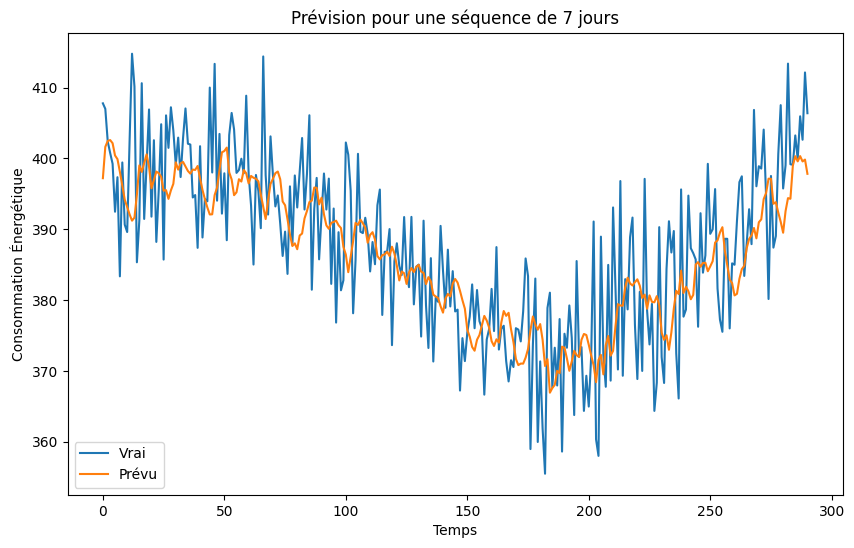

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation Metrics:
Mean Squared Error (MSE): 0.0037
Mean Absolute Error (MAE): 0.0486
R-squared (R^2): 0.5376


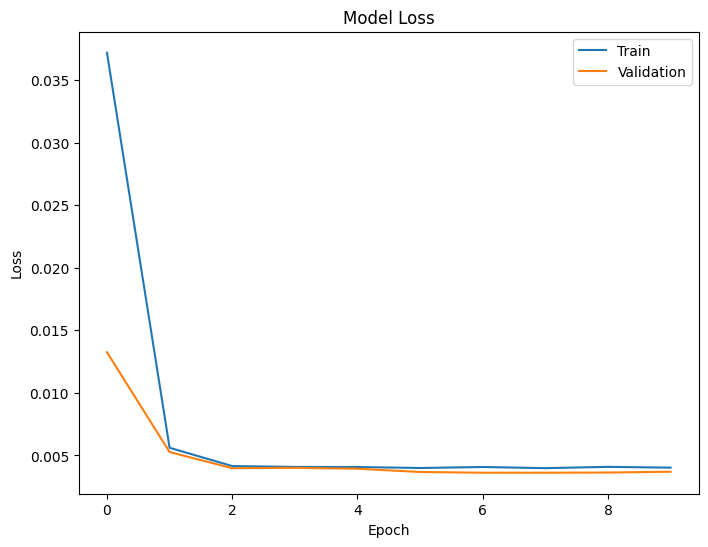

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


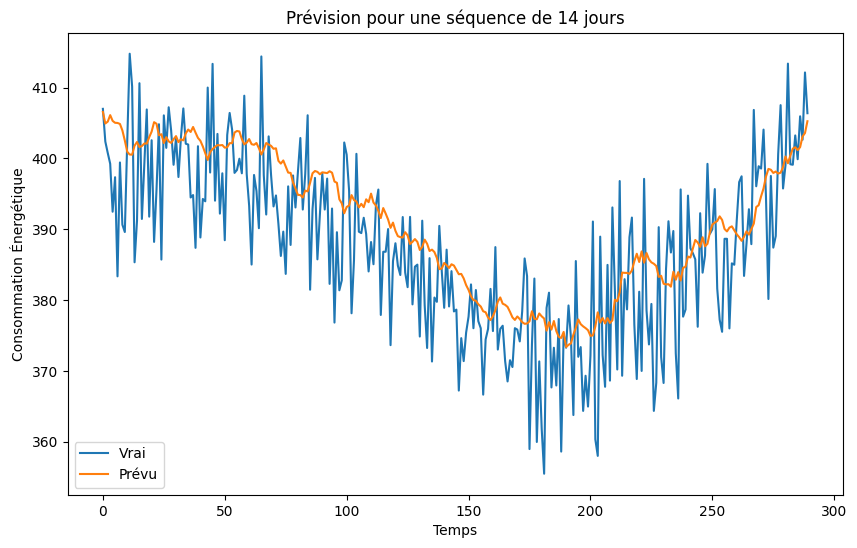

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation Metrics:
Mean Squared Error (MSE): 0.0041
Mean Absolute Error (MAE): 0.0518
R-squared (R^2): 0.4885


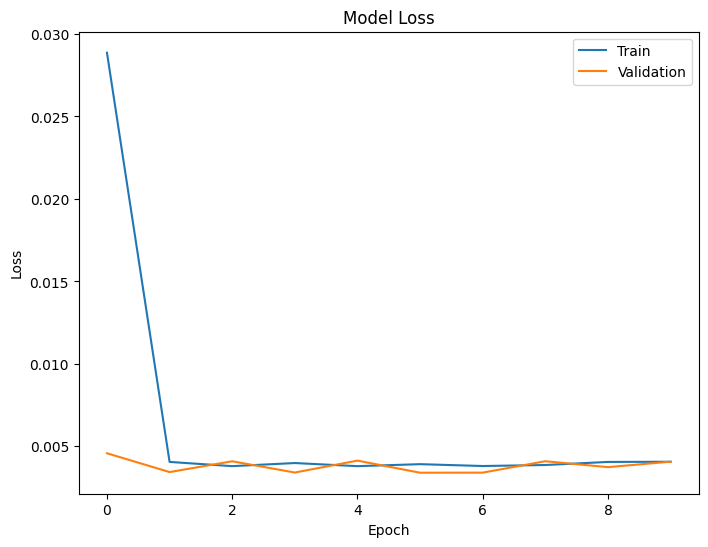

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


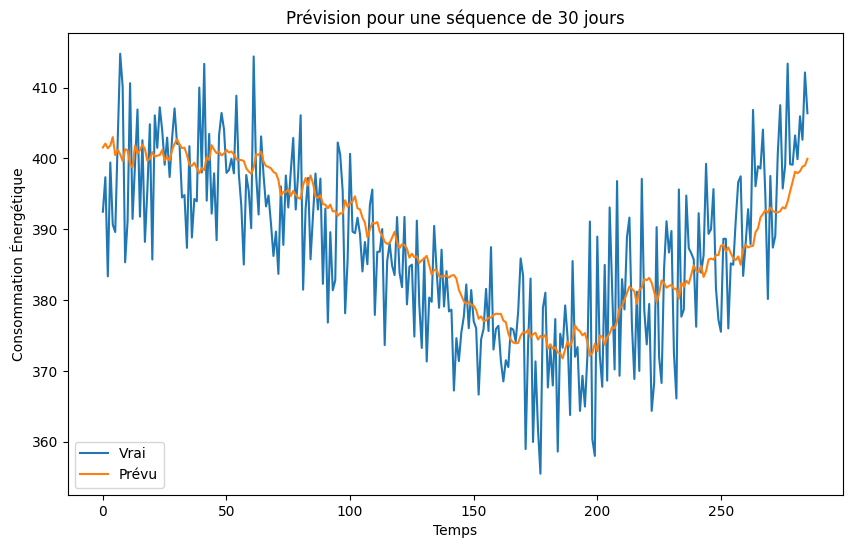

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluation Metrics:
Mean Squared Error (MSE): 0.0036
Mean Absolute Error (MAE): 0.0483
R-squared (R^2): 0.5497


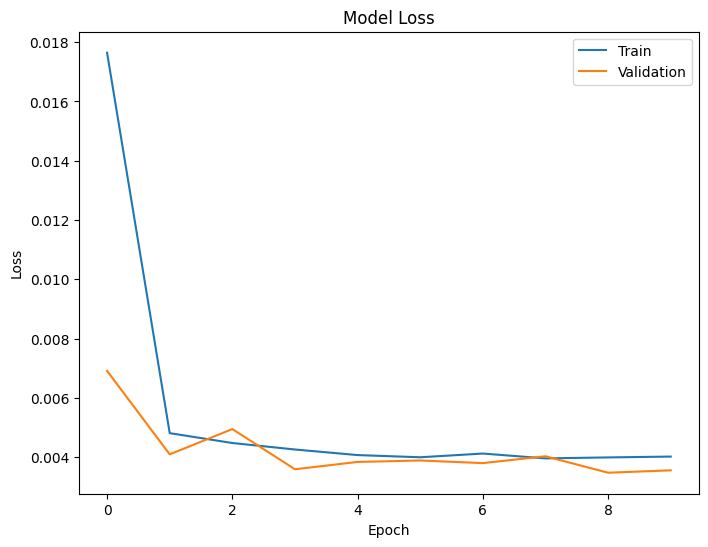

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


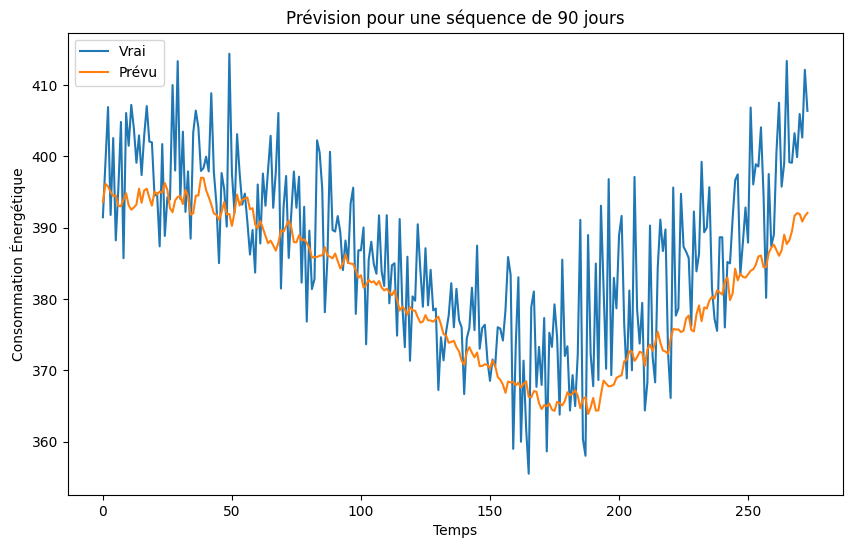

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Evaluation Metrics:
Mean Squared Error (MSE): 0.0051
Mean Absolute Error (MAE): 0.0566
R-squared (R^2): 0.3442


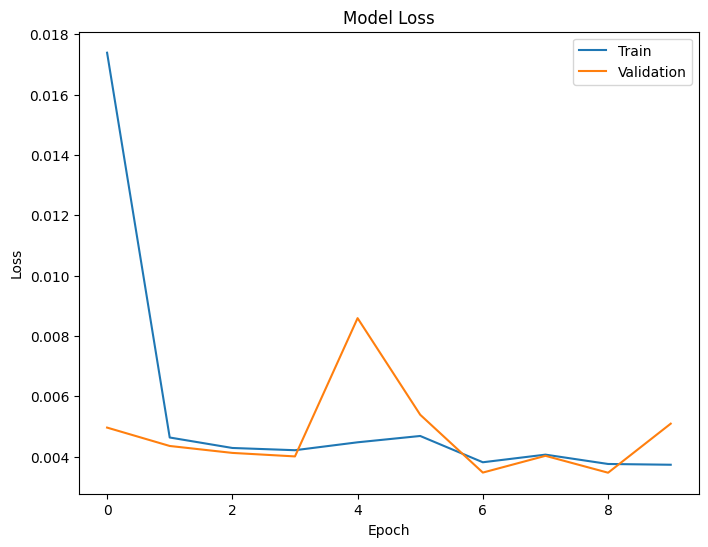

In [308]:
for seq_length in sequence_lengths:
    X, y = create_sequences(scaled_data, seq_length)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = create_cnn_model(X_train.shape[1:])
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=0)
    history_dict[seq_length] = history.history

    # Prédictions et dénormalisation
    y_pred = model.predict(X_test)
    y_test_rescaled = scaler.inverse_transform(y_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)

    # Visualisation des résultats
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_rescaled, label='Vrai')
    plt.plot(y_pred_rescaled, label='Prévu')
    plt.title(f'Prévision pour une séquence de {seq_length} jours')
    plt.xlabel('Temps')
    plt.ylabel('Consommation Énergétique')
    plt.legend()
    plt.show()

    evaluate_model(model, history.history, X_test, y_test)

In [ ]:
X, y = create_sequences(scaled_data, 7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


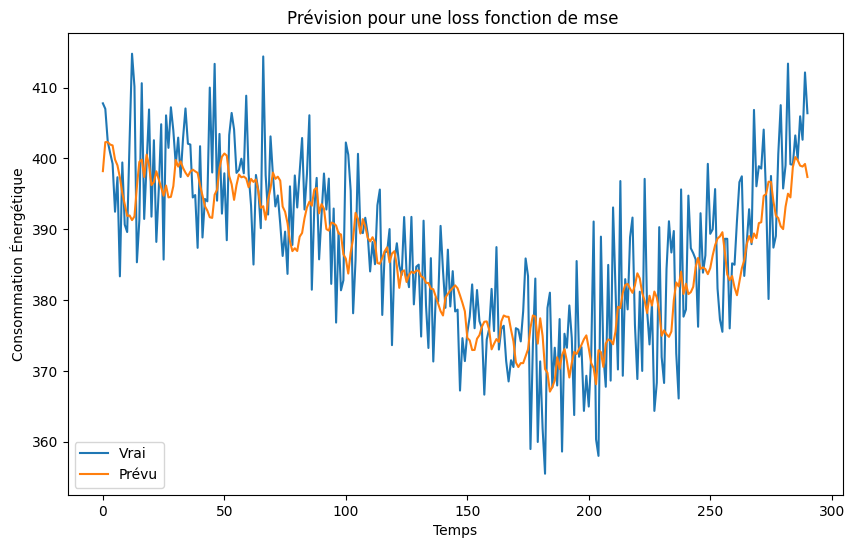

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluation Metrics:
Mean Squared Error (MSE): 0.0037
Mean Absolute Error (MAE): 0.0485
R-squared (R^2): 0.5376


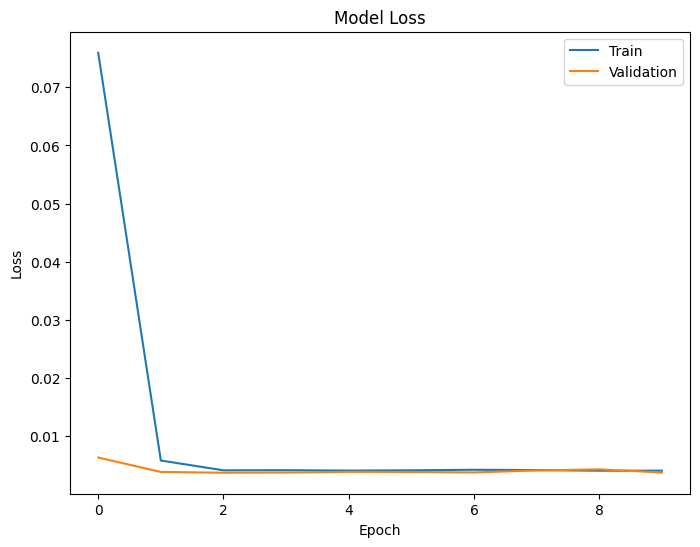

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


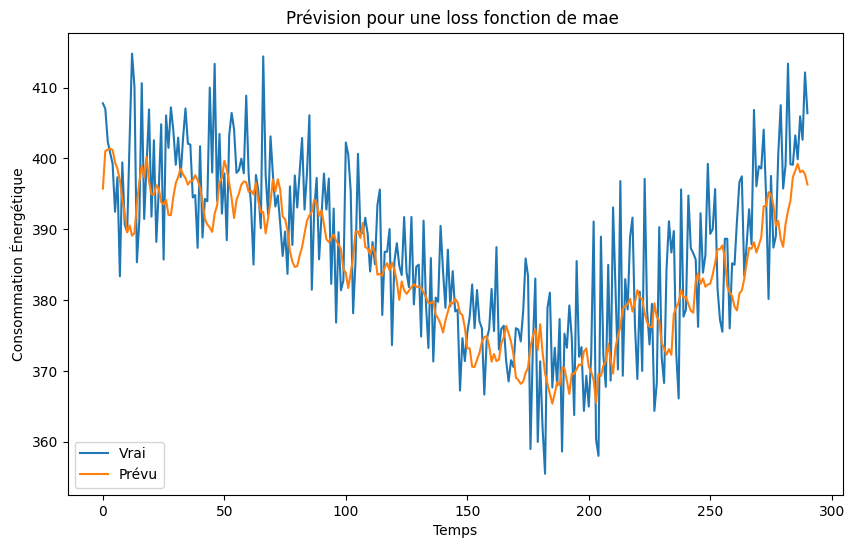

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation Metrics:
Mean Squared Error (MSE): 0.0042
Mean Absolute Error (MAE): 0.0520
R-squared (R^2): 0.4731


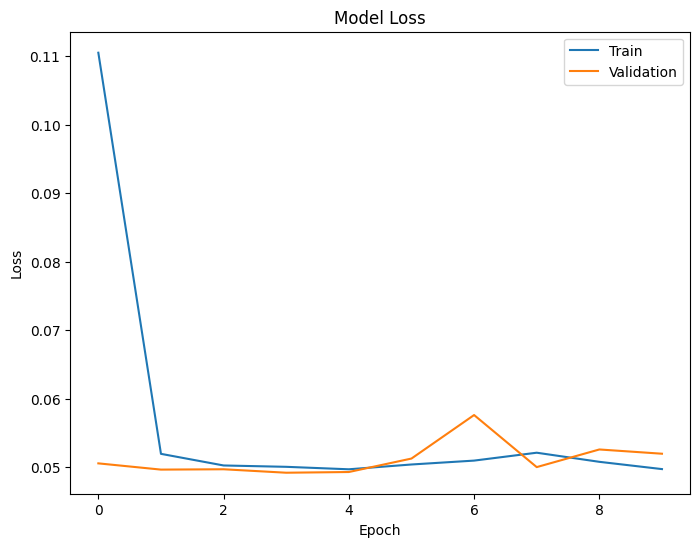

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


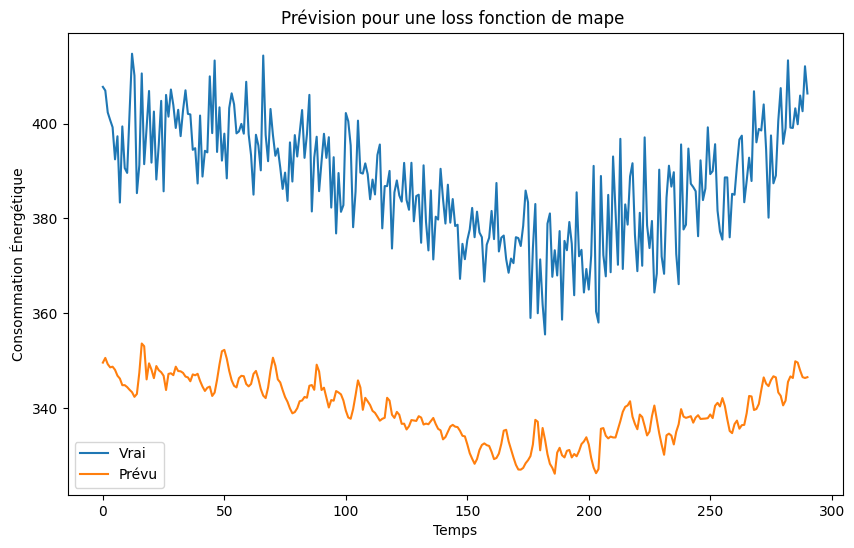

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation Metrics:
Mean Squared Error (MSE): 0.1262
Mean Absolute Error (MAE): 0.3492
R-squared (R^2): -14.7712


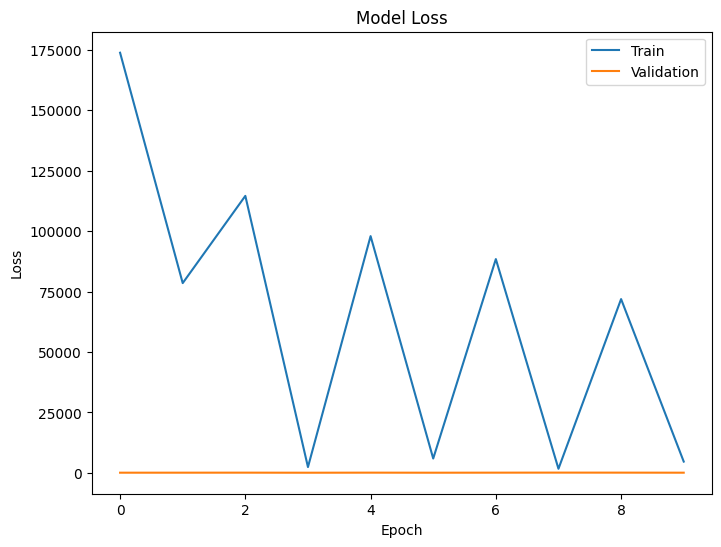

In [309]:
for loss_function in loss_functions:
    model = create_cnn_model(X_train.shape[1:],loss_functions = loss_function)
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=0)
    history_dict[loss_function] = history.history

    # Prédictions et dénormalisation
    y_pred = model.predict(X_test)
    y_test_rescaled = scaler.inverse_transform(y_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)

    # Visualisation des résultats
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_rescaled, label='Vrai')
    plt.plot(y_pred_rescaled, label='Prévu')
    plt.title(f'Prévision pour une loss fonction de {loss_function} ')
    plt.xlabel('Temps')
    plt.ylabel('Consommation Énergétique')
    plt.legend()
    plt.show()

    evaluate_model(model, history.history, X_test, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


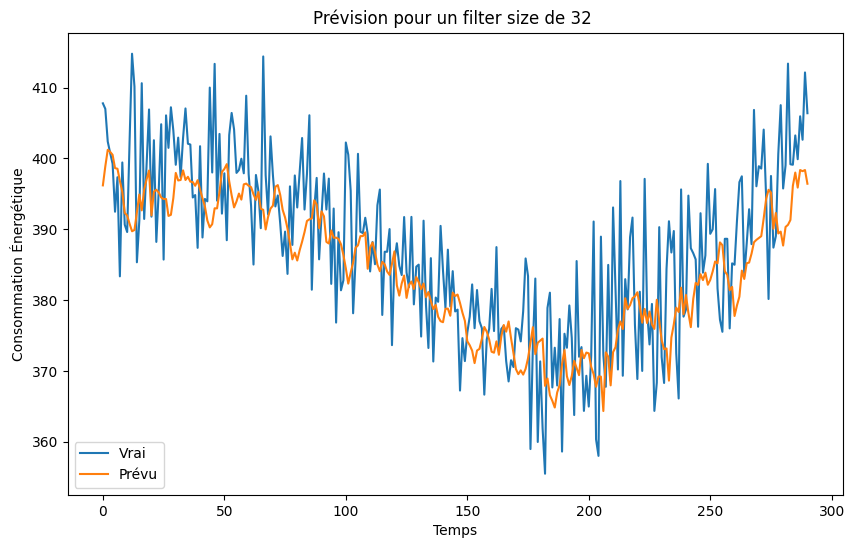

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation Metrics:
Mean Squared Error (MSE): 0.0041
Mean Absolute Error (MAE): 0.0511
R-squared (R^2): 0.4851


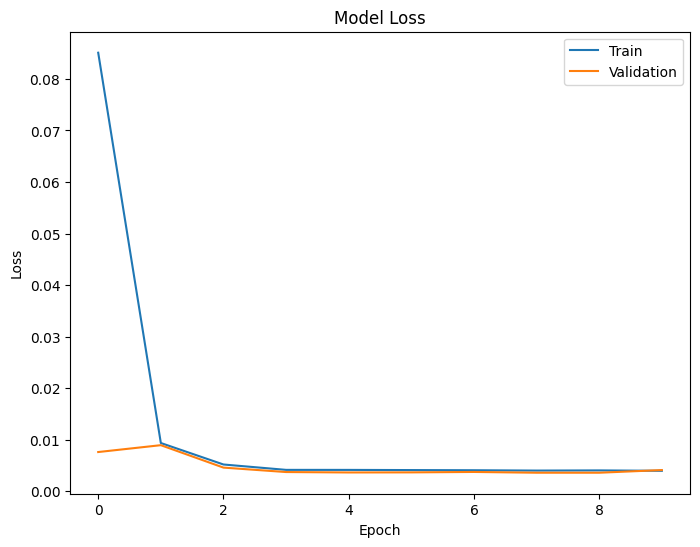

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


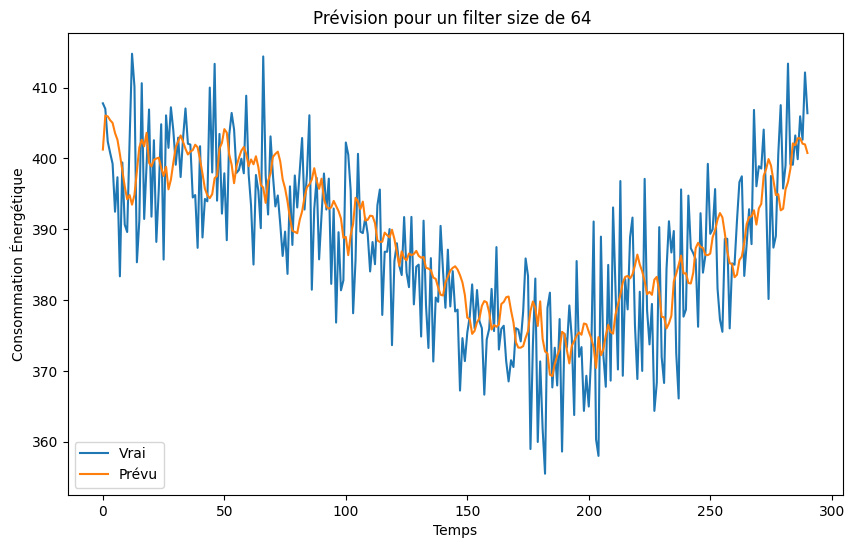

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation Metrics:
Mean Squared Error (MSE): 0.0037
Mean Absolute Error (MAE): 0.0494
R-squared (R^2): 0.5349


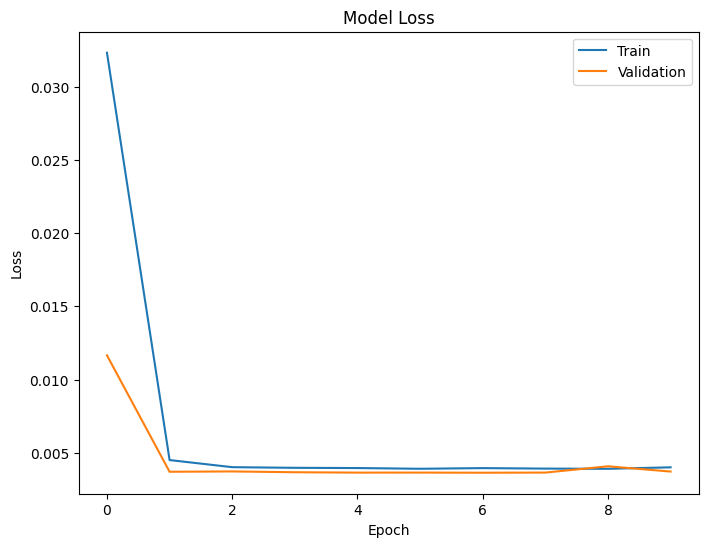

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


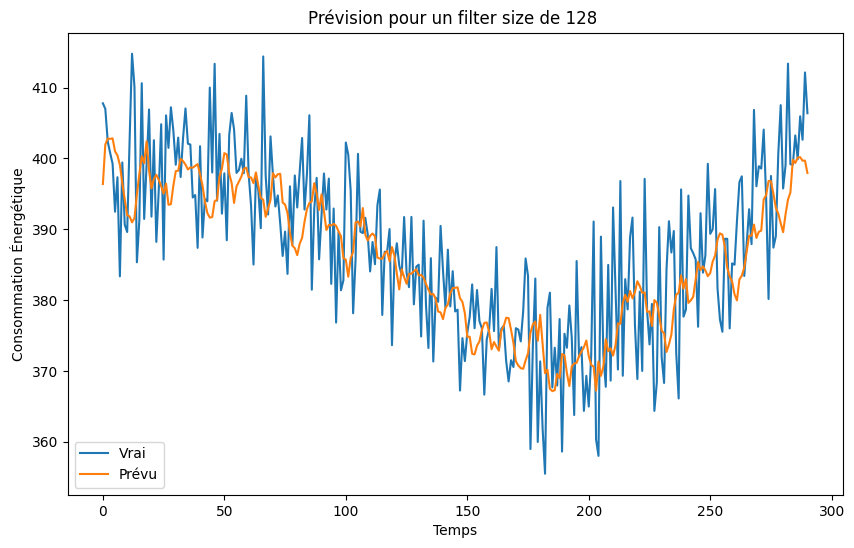

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation Metrics:
Mean Squared Error (MSE): 0.0038
Mean Absolute Error (MAE): 0.0495
R-squared (R^2): 0.5225


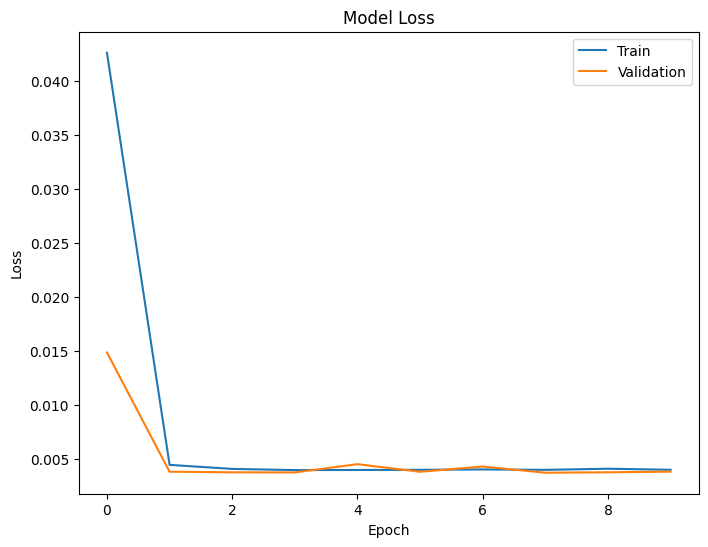

In [312]:
for filter_size in filter_sizes:
    model = create_cnn_model(X_train.shape[1:],loss_functions = 'mse', filter_sizes = filter_size)
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=0)
    history_dict[filter_size] = history.history

    # Prédictions et dénormalisation
    y_pred = model.predict(X_test)
    y_test_rescaled = scaler.inverse_transform(y_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)

    # Visualisation des résultats
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_rescaled, label='Vrai')
    plt.plot(y_pred_rescaled, label='Prévu')
    plt.title(f'Prévision pour un filter size de {filter_size} ')
    plt.xlabel('Temps')
    plt.ylabel('Consommation Énergétique')
    plt.legend()
    plt.show()

    evaluate_model(model, history.history, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


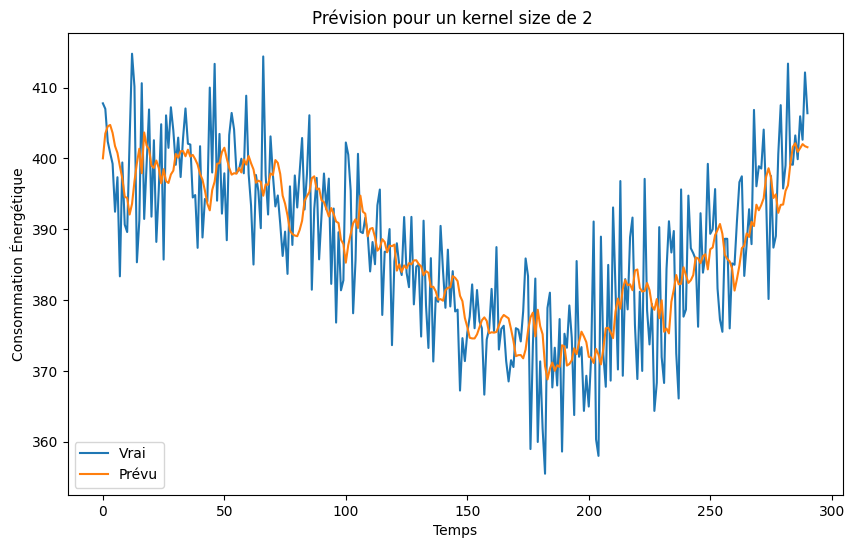

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluation Metrics:
Mean Squared Error (MSE): 0.0036
Mean Absolute Error (MAE): 0.0479
R-squared (R^2): 0.5520


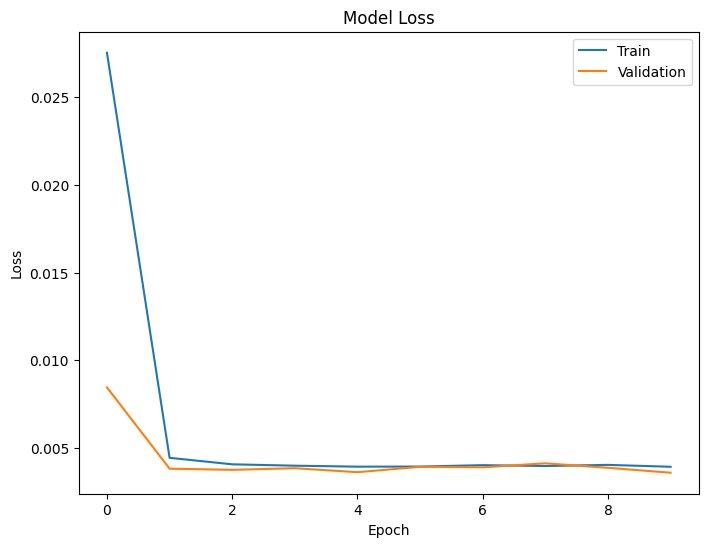

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


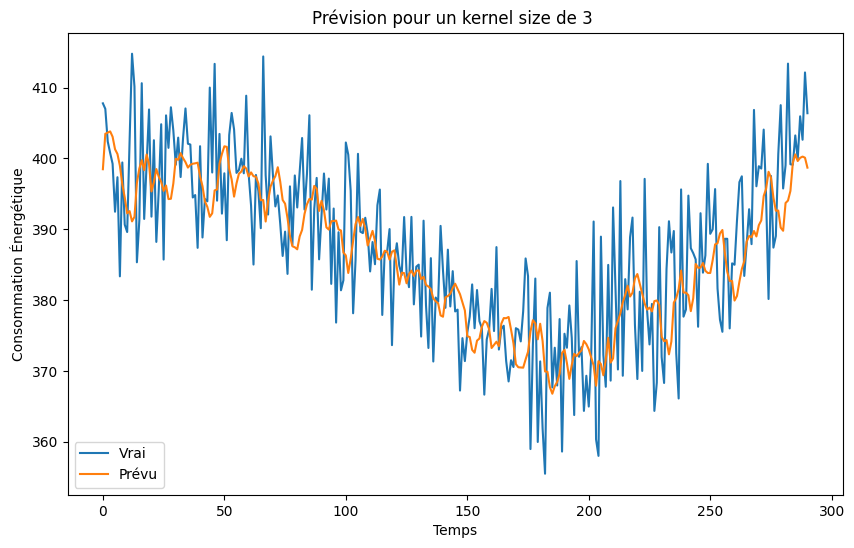

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Evaluation Metrics:
Mean Squared Error (MSE): 0.0037
Mean Absolute Error (MAE): 0.0484
R-squared (R^2): 0.5357


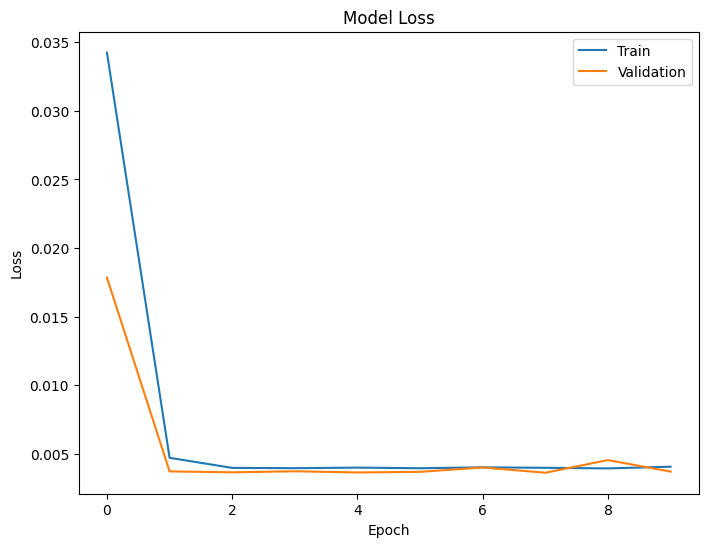

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


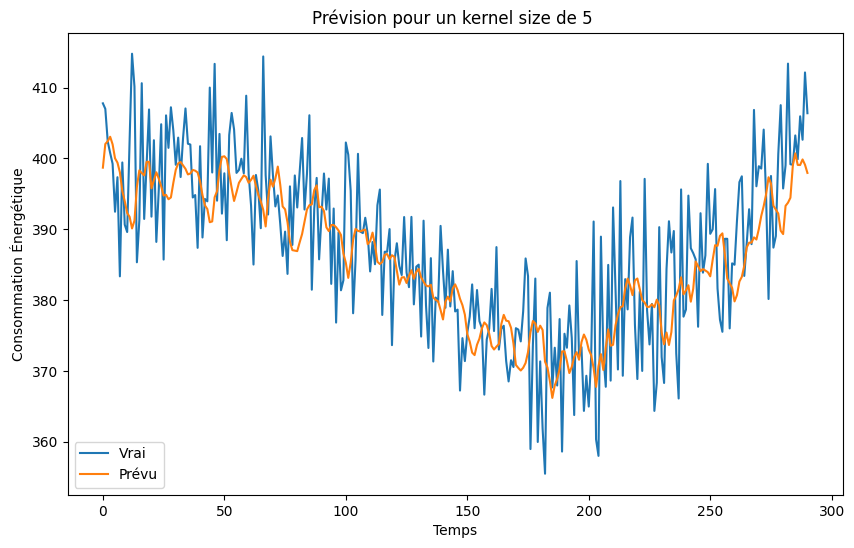

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluation Metrics:
Mean Squared Error (MSE): 0.0037
Mean Absolute Error (MAE): 0.0485
R-squared (R^2): 0.5330


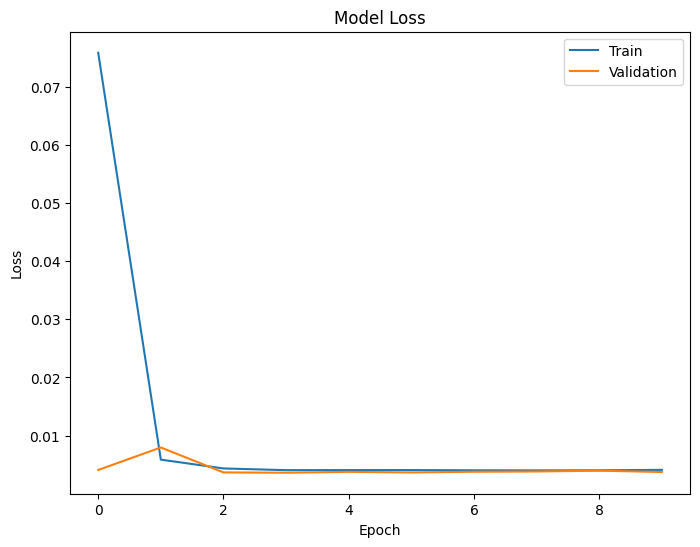

In [313]:
for kernel_size in kernel_sizes:
    model = create_cnn_model(X_train.shape[1:],loss_functions = 'mse', filter_sizes = 128, kernel_sizes = kernel_size)
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=0)
    history_dict[kernel_size] = history.history

    # Prédictions et dénormalisation
    y_pred = model.predict(X_test)
    y_test_rescaled = scaler.inverse_transform(y_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)

    # Visualisation des résultats
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_rescaled, label='Vrai')
    plt.plot(y_pred_rescaled, label='Prévu')
    plt.title(f'Prévision pour un kernel size de {kernel_size} ')
    plt.xlabel('Temps')
    plt.ylabel('Consommation Énergétique')
    plt.legend()
    plt.show()

    evaluate_model(model, history.history, X_test, y_test)